# BigQuery Commands

Cloud Datalab provides a first class experience for working with BigQuery for both adhoc, exploratory work as well as pipeline development. In addition to authoring and executing SQL queries, you'll likely find the need to inspect DataSets, Tables, and their Schema, as well as sample data.

This notebook introduces various BigQuery commands that Cloud Datalab introduces into the notebook environment.

You've already seen the use of `%%sql` in the [Hello BigQuery](Hello BigQuery.ipynb) notebook. The BigQuery commands are invoked using `%%bigquery`.

## Commands, literally

You can think of `%%bigquery` as your command-line interface to BigQuery. These commands take arguments, including `--help`, as you might be used to with other commands on an actual shell prompt. Lets start by checking out the help.

In [1]:
%bigquery --help

usage: bigquery [-h]
                {sample,dryrun,udf,execute,pipeline,table,schema,datasets,tables,extract,load}
                ...

Execute various BigQuery-related operations. Use "%bigquery <command> -h" for
help on a specific command.

positional arguments:
  {sample,dryrun,udf,execute,pipeline,table,schema,datasets,tables,extract,load}
                        commands
    sample              Display a sample of the results of a BigQuery SQL
                        query. The cell can optionally contain arguments for
                        expanding variables in the query, if -q/--query was
                        used, or it can contain SQL for a query.
    dryrun              Execute a dry run of a BigQuery query and display
                        approximate usage statistics
    udf                 Create a named Javascript BigQuery UDF
    execute             Execute a BigQuery SQL query and optionally send the
                        results to a named table. The cell ca

You can then get help on any of the individual commands as follows:

In [2]:
%bigquery tables --help

usage: bigquery tables [-h] [-p PROJECT] [-d DATASET]

optional arguments:
  -h, --help            show this help message and exit
  -p PROJECT, --project PROJECT
                        The project whose tables should be listed
  -d DATASET, --dataset DATASET
                        The dataset to restrict to


# Listing BigQuery Resources

The first thing you might decide to do is list datasets, and contained tables within a specified project, or by default, the project you're running this Cloud Datalab environment within.

Note, that you will be able to list, and use any BigQuery datasets that have been shared out with the project (i.e. its service account) that you are using to run Cloud Datalab.

In [3]:
%bigquery datasets --project cloud-datalab-samples

In [4]:
%bigquery tables --dataset cloud-datalab-samples:httplogs

# Exploring Data

Once you've found a table, or set of tables to work with, its simple to retrieve its schema or some sampling of rows to understand the data you're working with.

## Schema

In [5]:
%bigquery schema --table cloud-datalab-samples:httplogs.logs_20140615

## Sample Data

In [6]:
%bigquery sample --help

usage: bigquery sample [-h] [-q QUERY | -t TABLE | -v VIEW] [-c COUNT]
                       [-m {limit,random,hashed,sorted}] [-p PERCENT]
                       [-f FIELD] [-o {ascending,descending}] [--verbose]

optional arguments:
  -h, --help            show this help message and exit
  -q QUERY, --query QUERY
                        the name of the query to sample
  -t TABLE, --table TABLE
                        the name of the table to sample
  -v VIEW, --view VIEW  the name of the view to sample
  -c COUNT, --count COUNT
                        The number of rows to limit to, if sampling
  -m {limit,random,hashed,sorted}, --method {limit,random,hashed,sorted}
                        The type of sampling to use
  -p PERCENT, --percent PERCENT
                        For random or hashed sampling, what percentage to
                        sample from
  -f FIELD, --field FIELD
                        The field to use for sorted or hashed sampling
  -o {ascending,descending}, --

As you can see, Cloud Datalab allows you to sample a specified count of rows, using various sampling strategies, including random sampling, or hashing. Lets try retrieving a couple samples.

In [7]:
%bigquery sample --table cloud-datalab-samples:httplogs.logs_20140615 --count 5

timestamp,latency,status,method,endpoint
2014-06-15 07:00:00.003772,122,200,GET,Interact3
2014-06-15 07:00:00.428897,144,200,GET,Interact3
2014-06-15 07:00:00.536486,48,200,GET,Interact3
2014-06-15 07:00:00.652760,28,405,GET,Interact2
2014-06-15 07:00:00.670100,103,200,GET,Interact3


In [8]:
%bigquery sample --table cloud-datalab-samples:httplogs.logs_20140615 --count 10 --field timestamp --method hashed

timestamp,latency,status,method,endpoint
2014-06-15 07:00:05.449186,6,302,GET,Other
2014-06-15 07:00:05.908400,5,302,GET,Other
2014-06-15 07:00:09.078710,30,405,GET,Interact2
2014-06-15 07:00:18.609836,28,200,GET,Other
2014-06-15 07:00:18.861028,119,200,GET,Other
2014-06-15 07:00:25.316129,712,200,GET,Interact3
2014-06-15 07:00:28.423380,211,404,GET,Other
2014-06-15 07:00:46.074430,501,200,GET,Other
2014-06-15 07:00:51.734565,124,200,GET,Other
2014-06-15 07:00:53.029076,121,405,GET,Interact2


# Querying Data

Of course, querying BigQuery data using SQL is the mainline scenario. Its always handy to have the BigQuery SQL reference. Cloud Datalab makes this easy to access by providing a direct link to the [query reference](https://cloud.google.com/bigquery/query-reference) via the Help button on the top toolbar.

Lets see an example of this.

In [9]:
%%sql
SELECT timestamp, latency
FROM [cloud-datalab-samples:httplogs.logs_20140615]
ORDER BY latency DESC
LIMIT 10

timestamp,latency
2014-06-15 10:15:06.354093,13500918
2014-06-15 09:15:04.571911,13500391
2014-06-15 10:00:05.264877,13500340
2014-06-15 09:45:04.873233,13500166
2014-06-15 09:30:07.401665,13500118
2014-06-16 00:01:45.311564,1197339
2014-06-15 15:17:12.987435,136467
2014-06-15 15:16:33.290520,130296
2014-06-15 15:15:56.727494,121277
2014-06-15 15:15:58.259215,97192


That was a simple query. Now, lets do something a bit more interesting. Lets compute the 50th percentile, 95th percentile and 99th percentile latencies for request processing.

BigQuery makes this effortless with all of its built-in statistical and analytics functions such as `QUANTILES` and `NTH`.

In [10]:
%%sql
SELECT
  NTH(50, quantiles) AS latency_50th_percentile,
  NTH(95, quantiles) AS latency_95th_percentile,
  NTH(99, quantiles) AS latency_99th_percentile
FROM (
  SELECT QUANTILES(latency, 100) AS quantiles
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
)

latency_50th_percentile,latency_95th_percentile,latency_99th_percentile
81,462,15204


# Visualizing Data

Beyond tables, it almost always interesting to be able to visualize the data to get a more meaningful view of aggregates, trends and patterns.

Lets write another query, also using `QUANTILES`. This time the `ROW_NUMBER` function will be used to also include a row number in the output data representing the percentile, and use that as the x-axis value in a chart. In order to reference this SQL query in the chart, it is converted into a SQL module via the `--module` argument. This module can then be that can be passed on to the chart referencing it by name. The chart will execute the contained query.

In [11]:
%%sql --module data
SELECT ROW_NUMBER() OVER (ORDER BY time) AS percentile, time
FROM (
  SELECT QUANTILES(LOG10(latency), 50) AS time
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
)

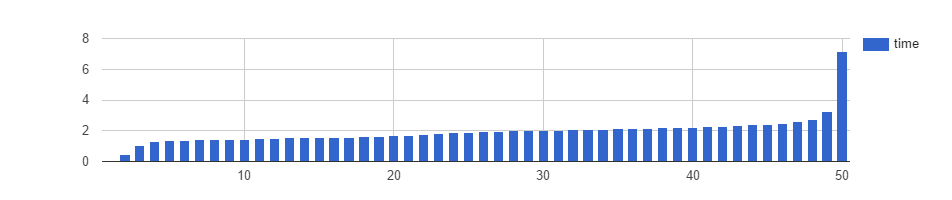

In [12]:
%chart columns --data data --fields percentile,time

# Looking Ahead

There are various other commands such as the ones to import (or load) and export (or extract) data, or to create pipelines (or transform) data to build **ETL pipelines**.

Cloud Datalab allows creating **parameterized queries**, so queries can be modified using variables defined in the notebook during interactive work, or through pipeline commands when these are deployed. Queries can be declared and validated one step-at-a-time to create **composite SQL queries** that harness the full power of BigQuery SQL, while managing authoring complexity.

All of these BigQuery commands are implemented on top of **Python BigQuery APIs** (in the `gcp.bigquery` Python module) which not only allow you to write arbitrary code and logic while working with BigQuery data, but also integrate SQL and Python, and the Python data analysis libraries such as pandas and matplotlib to perform sophisticated and custom data analysis and visualization tasks.

These topics will be covered in additional notebooks within the BigQuery tutorials included along with Cloud Datalab.